## Бгатцев А.В. ИУ5-21М РК2

# Задание
Необходимо решить задачу кластеризации на основе любого выбранного Вами датасета.

Кластеризуйте данные с помощью трех различных алгоритмов кластеризации. Алгоритмы выбираются произвольным образом, рекомендуется использовать алгоритмы из лекции.

Сравните качество кластеризации для трех алгоритмов с помощью следующих метрик качества кластеризации:

Adjusted Rand index
Adjusted Mutual Information
Homogeneity, completeness, V-measure
Коэффициент силуэта
Сделате выводы о том, какой алгоритм осуществляет более качественную кластеризацию на Вашем наборе данных.

# Кластеризация ([Кластерный анализ](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7))

In [0]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import silhouette_score
from itertools import cycle, islice
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Задача кластеризации относится к задачам [обучения без учителя.](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B5%D0%B7_%D1%83%D1%87%D0%B8%D1%82%D0%B5%D0%BB%D1%8F)

В случае обучения без учителя присутствуют только исходные признаки матрицы $X$. Целевой признак $y$ отсутствует. Не стаивится задачи предсказания целевого признака по исходным признакам.

В случае кластеризации задача ставится следующим образом: каждому объекту матрицы $X$ поставить в соответствие определенную метку кластера из множества возможных кластеров $C$. При визуализации метка кластера обычно выделяется цветом.

Количество кластеров зависит от используемого алгоритма. В некоторых алгоритмах количество кластеров является гиперпараметром и должно быть задано на входе алгоритма. В некоторых алгоритмах оно подбирается автоматически.

В завимости от используемого алгоритма результаты кластеризации могут сильно различаться.

Как и в случае обучения с учителем, существуют метрики качества, которые позволяют измерить качество кластеризации. 

Задача кластеризации успешно решается с помощью библиотеки [scikit-learn.](https://scikit-learn.org/stable/modules/clustering.html)

### Для чего используется кластеризация?

- Понимание данных путём выявления кластерной структуры. Разбиение выборки на группы позволяет понять структуру данных исследуемой предметной области. Исторически это один из первых видов анализа данных.
- Разбиение выборки на группы схожих объектов позволяет упростить дальнейшую обработку данных и принятия решений, применяя к каждому кластеру свой метод анализа.
- Сжатие данных. Если исходная выборка избыточно большая, то можно сократить её, оставив по одному наиболее типичному представителю от каждого кластера.
- Обнаружение новизны (англ. novelty detection). Выделяются нетипичные объекты, которые не удаётся присоединить ни к одному из кластеров.

В биологии и гуманитарных науках (истории, социологии) кластеризация имеет множество приложений в самых разных областях. 
- Например, в биоинформатике с помощью неё анализируются сложные сети взаимодействующих генов, состоящие порой из сотен или даже тысяч элементов. 
- В области экологии широко применяется для выделения пространственно однородных групп организмов, сообществ и т. п. Реже методы кластерного анализа применяются для исследования сообществ во времени.

Примеры алгоритмов кластеризации:

Можно отметить, что результаты работы алгоритмов очень разнятся между собой. 

In [0]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/MMO/rk2/agg.csv', sep=";",header=None)
cluster_dataset_x=np.hsplit(data.values,(2,2))[0]
cluster_dataset_y=np.hsplit(data.values,(2,2))[2].astype(np.int64)

array([7])

## Генерация наборов данных

Для тестирования алгоритмов кластеризации в scikit-learn существуют [генераторы](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) которые позволяют сгенерировать наборы данных определенного вида. Наборы данных содержат 2 числовых признака для удобства визуализации на плоскости.


In [0]:
cluster_n_samples = 1500

datasets_names = ['circles', 'moons', 'blobs', 'aniso', 'varied', 'no_structure']


def generate_datasets(n_samples):
    """
    Генерация набора данных на 1500 точек
    """
    noisy_circles, noisy_circles_y = datasets.make_circles(
        n_samples=n_samples, factor=.5, noise=.05)
    noisy_moons, noisy_moons_y = datasets.make_moons(n_samples=n_samples, noise=.05)
    blobs, blobs_y = datasets.make_blobs(n_samples=n_samples, random_state=8)
    no_structure = np.random.rand(n_samples, 2)
  
    X_aniso, y_aniso = datasets.make_blobs(n_samples=n_samples, random_state=170)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    aniso = np.dot(X_aniso, transformation)

    varied, varied_y = datasets.make_blobs(
        n_samples=n_samples, 
        cluster_std=[1.0, 2.5, 0.5], 
        random_state=170)
    
    result_y = [noisy_circles_y, noisy_moons_y, varied_y, y_aniso, blobs_y]
    
    result_not_scaled = [noisy_circles, noisy_moons, 
                         varied, aniso, blobs, no_structure]
    
    # Нормализуем признаки
    result = []
    for data in result_not_scaled:
        data_res = StandardScaler().fit_transform(data)
        result.append(data_res)
    
    return result, result_y

In [0]:
cluster_datasets, cluster_true_y = generate_datasets(cluster_n_samples)

In [0]:
def visualize_clusters(cluster_dataset, cluster_result):
    """
    Визуализация результатов кластерного анализа
    """
    # Цвета точек как результат кластеризации
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(cluster_result) + 1))))
    # черный цвет для выделяющихся значений
    colors = np.append(colors, ["#000000"])
    plt.scatter(cluster_dataset[:, 0], cluster_dataset[:, 1], s=3, color=colors[cluster_result])
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

In [0]:
cluster_results_empty = []
for i in range(6):
    cluster_results_empty.append(np.zeros(cluster_n_samples, dtype=int))

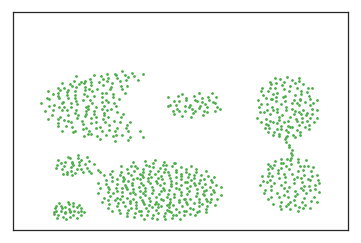

In [0]:
# Нет кластеров
visualize_clusters(cluster_dataset_x, cluster_dataset_y)

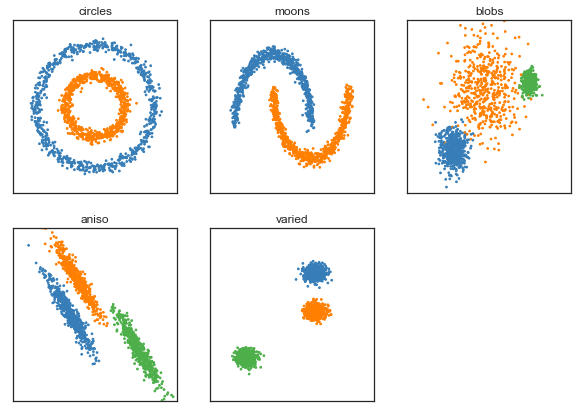

In [0]:
# Эталонные значения кластеров
visualize_clusters(cluster_datasets, cluster_true_y)

## [Метод k-средних](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B8%D1%85)

Реализован в библиотеке scikit-learn с помощью класса [KMeans.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Также реализована версия [k-means++](https://ru.wikipedia.org/wiki/K-means%2B%2B) — улучшенная версия алгоритма кластеризации k-means. Суть улучшения заключается в нахождении более «хороших» начальных значений центроидов кластеров. 

Также реализован вариант алгоритма Mini Batch K-Means с помощью класса [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html), который сходится быстрее, но обычно проигрывает по качеству кластеризации.

Основная проблема алгоритма состоит в том, что количество кластеров задается как гиперпараметр.

In [0]:
def do_clustering(cluster_datasets, method):
    """
    Выполнение кластеризации для данных примера
    """
    cluster_results = []
    for X in cluster_datasets:
        temp_cluster = method.fit_predict(X)
        cluster_results.append(temp_cluster)
    return cluster_results

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [0]:
%time result_KMeans_3 = do_clustering(cluster_datasets, KMeans(n_clusters=3))

Wall time: 209 ms


In [0]:
%time result_KMeans_5 = do_clustering(cluster_datasets, KMeans(n_clusters=5))

Wall time: 342 ms


In [0]:
%time result_KMeans_plus_3 = do_clustering(cluster_datasets, KMeans(n_clusters=3, init='k-means++'))

Wall time: 221 ms


In [0]:
%time result_KMeans_batch_3 = do_clustering(cluster_datasets, MiniBatchKMeans(n_clusters=3))

Wall time: 88.3 ms


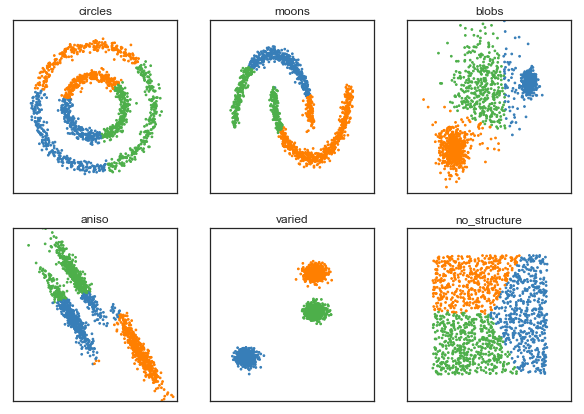

In [0]:
visualize_clusters(cluster_datasets, result_KMeans_3)

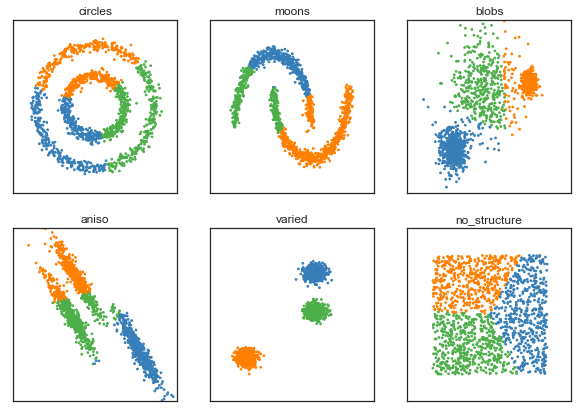

In [0]:
visualize_clusters(cluster_datasets, result_KMeans_plus_3)

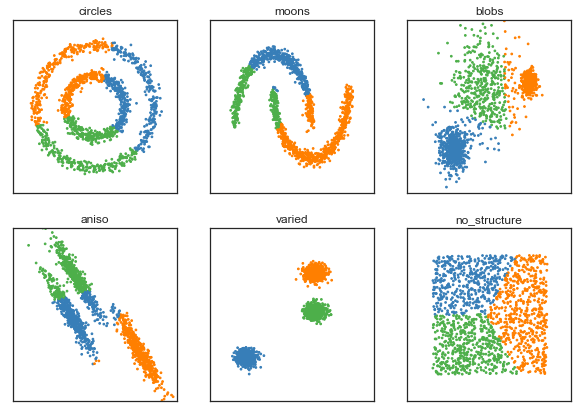

In [0]:
visualize_clusters(cluster_datasets, result_KMeans_batch_3)

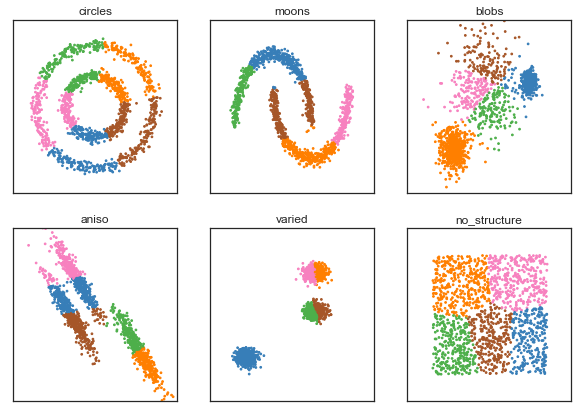

In [0]:
visualize_clusters(cluster_datasets, result_KMeans_5)

### Как лучше выбирать гиперпараметр количества кластеров?

Для этого можно использовать "правило локтя".

Если $C$ – множество кластеров мощности $K$, а $\mu_k$ – центроид кластера  $C_k$, то инерция (сумма квадратов расстояний от точек до центроидов кластеров) вычисляется по следующей формуле:

$$ J(C) = \sum\limits_{k=1}^{K} \sum\limits_{i \in C_k} (x_i - \mu_k)^2 $$

Инерцию необходимо минимизировать по количеству кластеров:

$$ J(C) \rightarrow min_C  $$

Используется следующее решение -  выбирают такое число кластеров, начиная с которого уменьшение $J(C)$ замедляется:

$$ \frac{J(C_k) - J(C_{k+1})}{J(C_{k-1}) - J(C_k)} \rightarrow min_k $$

Рассмотрим следующий пример:

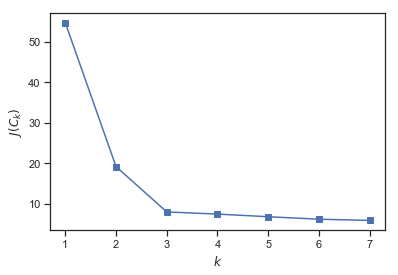

In [0]:
inertia = []
TEMP_X = cluster_datasets[4]
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(TEMP_X)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Здесь результат четко выражен - после 3 кластеров уменьшение инерции резко замедляется. 

Для многих случаев явно выраженный "локоть" может не наблюдаться.

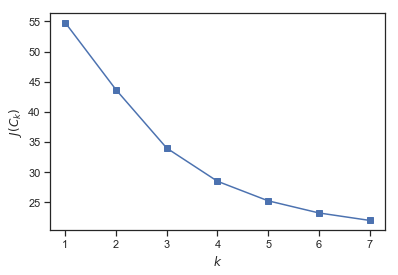

In [0]:
inertia = []
TEMP_X = cluster_datasets[0]
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(TEMP_X)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## Метрики качества кластеризации

### 1) [Adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index)

Метрика применяется в том случае, если известны истинные метки классов. Для вычисления метрики используется функция [adjusted_rand_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) Отчасти метрика напоминает accuracy, так как сравнивает полученные метки классов с известными истинными классами.

Метрика возвращает результат в диапазоне [-1;+1]. Значение близкое к +1 говорит об очень хорошем качестве кластеризации. Значение близкое к 0 соответствует случайным разбиениям. Отрицательные значения говорят о плохом качестве кластеризации.

### 2) [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information)

Для вычисления метрики используется функция [adjusted_mutual_info_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html)

Значение близкое к +1 говорит об очень хорошем качестве кластеризации. Значение близкое к 0 соответствует случайным разбиениям.

### 3) Homogeneity, completeness, V-measure

Для вычисления метрик используется функция [homogeneity_completeness_v_measure.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_completeness_v_measure.html)

- Homogeneity - каждый кластер содержит только представителей единственного класса (под классом понимается истинное значение метки кластера). Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
- Completeness - все элементы одного класса помещены в один и тот же кластер. Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
- V-measure - [среднее гармоническое](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5_%D0%B3%D0%B0%D1%80%D0%BC%D0%BE%D0%BD%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5) от Homogeneity и Completeness.

### 4) Коэффициент силуэта

Для вычисления метрики используется функция [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

Данный метод не требует знания истинных значений меток кластеров.

Пусть:

- $a$ - среднее расстояние между текущей точкой и другими точками этого же кластера.
- $b$ - среднее расстояние между текущей точкой и другими точками следующего ближайшего кластера.

Тогда коэффициент силуэта для точки (объекта) определяется как:

$$ s = \frac{b-a}{max(a,b)} $$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне [-1;1]. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров
(если оно заранее неизвестно) — выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def claster_metrics(method, cluster_datasets, cluster_true_y, datasets_names):
    """
    Вычисление метрик кластеризации
    """
    ari = []
    ami = []
    hl = []
    cl = []
    vl = []
    sl = []
    for X, true_y in zip(cluster_datasets, cluster_true_y):
        temp_cluster = method.fit_predict(X)
        ari.append(adjusted_rand_score(true_y, temp_cluster))
        ami.append(adjusted_mutual_info_score(true_y, temp_cluster))
    
        h, c, v = homogeneity_completeness_v_measure(true_y, temp_cluster)
        hl.append(h)
        cl.append(c)
        vl.append(v)
    
        sl.append(silhouette_score(X, temp_cluster))
    
    result = pd.DataFrame({'Datasets':datasets_names[0:5], 
                           'ARI':ari, 'AMI':ami, 
                           'Homogeneity':hl, 
                           'Completeness':cl, 
                           'V-measure':vl, 'Silhouette':sl})
    return result
    

In [0]:
# Вычисление метрик для KMeans
claster_metrics(KMeans(n_clusters=3), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,-0.000874,-0.000597,0.000017,0.000011,0.000014,0.388656
1,moons,0.377667,0.305118,0.468042,0.305555,0.369734,0.449693
2,blobs,0.809420,0.792724,0.792976,0.801360,0.797146,0.626163
3,aniso,0.607457,0.620723,0.621184,0.621331,0.621258,0.509969
4,varied,1.000000,1.000000,1.000000,1.000000,1.000000,0.810432


In [0]:
claster_metrics(KMeans(n_clusters=5), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,-0.000947,-0.000733,0.000229,0.000099,0.000138,0.362426
1,moons,0.303915,0.316126,0.723938,0.316703,0.440639,0.470690
2,blobs,0.762830,0.679587,0.885679,0.680186,0.769449,0.614957
3,aniso,0.414778,0.477187,0.689075,0.478070,0.564499,0.428911
4,varied,0.732813,0.706478,1.000000,0.706983,0.828343,0.534045


Продолжим изучение алгоритмов:

## [Affinity Propagation](https://en.wikipedia.org/wiki/Affinity_propagation)

Не требует задания количества кластеров в качестве гиперпараметра.

Реализован в библиотеке scikit-learn с помощью класса [AffinityPropagation.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html)

In [0]:
from sklearn.cluster import AffinityPropagation

In [0]:
%time result_AffinityPropagation = do_clustering(cluster_datasets, AffinityPropagation())

Wall time: 48.5 s


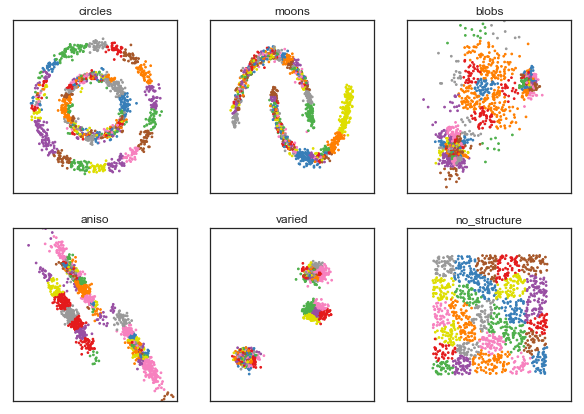

In [0]:
visualize_clusters(cluster_datasets, result_AffinityPropagation)

In [0]:
claster_metrics(AffinityPropagation(), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,0.033563,0.112531,1.000000,0.145228,0.253623,0.265268
1,moons,0.034251,0.075192,0.998667,0.129291,0.228942,0.144150
2,blobs,0.052657,0.186518,0.965605,0.222510,0.361677,0.149544
3,aniso,0.119197,0.226736,0.986166,0.260807,0.412517,0.233874
4,varied,0.118083,0.159200,1.000000,0.229441,0.373244,0.146411


## [Mean Shift](https://ru.wikipedia.org/wiki/%D0%A1%D0%B4%D0%B2%D0%B8%D0%B3_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B3%D0%BE_%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D1%8F)

Реализован в библиотеке scikit-learn с помощью класса [MeanShift.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

In [0]:
from sklearn.cluster import MeanShift

In [0]:
%time result_MeanShift = do_clustering(cluster_datasets, MeanShift())

Wall time: 44.8 s


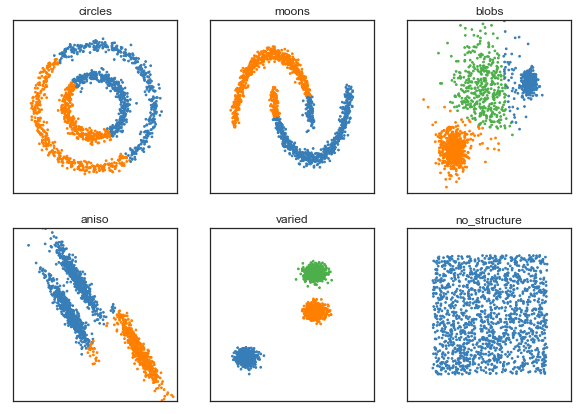

In [0]:
visualize_clusters(cluster_datasets, result_MeanShift)

In [0]:
claster_metrics(MeanShift(), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,-0.000089,-0.000065,0.000417,0.000418,0.000417,0.349036
1,moons,0.539428,0.435023,0.435295,0.435296,0.435295,0.499334
2,blobs,0.843232,0.822418,0.822634,0.828257,0.825436,0.625059
3,aniso,0.526632,0.493703,0.494011,0.841520,0.622554,0.618228
4,varied,1.000000,1.000000,1.000000,1.000000,1.000000,0.810432


## [Spectral clustering](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B5%D0%BA%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)

Реализован в библиотеке scikit-learn с помощью класса [SpectralClustering.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

In [0]:
from sklearn.cluster import SpectralClustering

In [0]:
%time result_SpectralClustering = do_clustering(cluster_datasets, SpectralClustering())

Wall time: 1.72 s


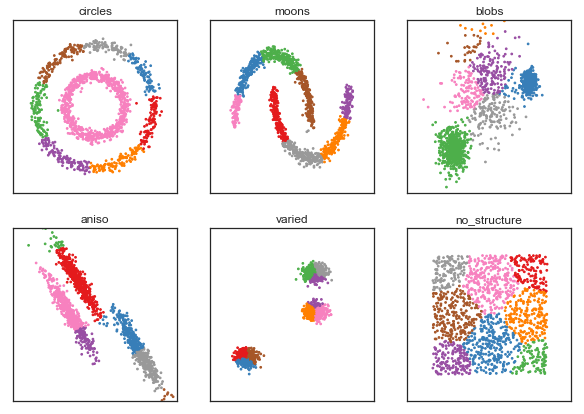

In [0]:
visualize_clusters(cluster_datasets, result_SpectralClustering)

In [0]:
claster_metrics(SpectralClustering(), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,0.569664,0.412756,0.994522,0.413582,0.584213,0.184151
1,moons,0.266517,0.335657,0.988859,0.336421,0.502041,0.491689
2,blobs,0.599225,0.551097,0.829095,0.552431,0.663061,0.452935
3,aniso,0.727598,0.668377,0.979881,0.669375,0.795398,0.359889
4,varied,0.407970,0.487709,0.921053,0.488869,0.638722,0.275952


## [Иерархическая кластеризация](https://ru.wikipedia.org/wiki/%D0%98%D0%B5%D1%80%D0%B0%D1%80%D1%85%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)

Группа методов, включающая агломеративные (объединение мелких кластеров) и дивизивные (разделение крупных кластеров) методы.

Количество кластеров задается как гиперпараметр алгоритма n_clusters.

Для агломеративной кластеризации в библиотеке scikit-learn используется класс [AgglomerativeClustering.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [0]:
%time result_AgglomerativeClustering = do_clustering(cluster_datasets, AgglomerativeClustering(n_clusters=3))

Wall time: 392 ms


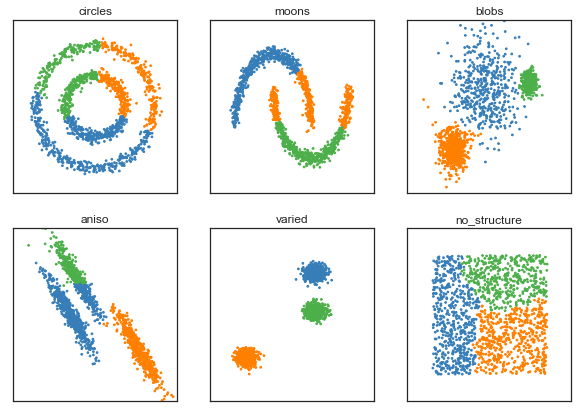

In [0]:
visualize_clusters(cluster_datasets, result_AgglomerativeClustering)

In [0]:
claster_metrics(AgglomerativeClustering(n_clusters=3), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,0.006309,0.004574,0.008042,0.005193,0.006311,0.344452
1,moons,0.489154,0.442491,0.699987,0.442831,0.542476,0.388760
2,blobs,0.960603,0.938280,0.938355,0.938585,0.938470,0.603804
3,aniso,0.685237,0.730558,0.730886,0.767582,0.748785,0.479917
4,varied,1.000000,1.000000,1.000000,1.000000,1.000000,0.810432


## Алгоритм [DBSCAN](https://ru.wikipedia.org/wiki/DBSCAN)

Реализован в библиотеке scikit-learn с помощью класса [DBSCAN.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [0]:
from sklearn.cluster import DBSCAN

In [0]:
%time result_DBSCAN = do_clustering(cluster_datasets, DBSCAN(eps=0.25))

Wall time: 99.3 ms


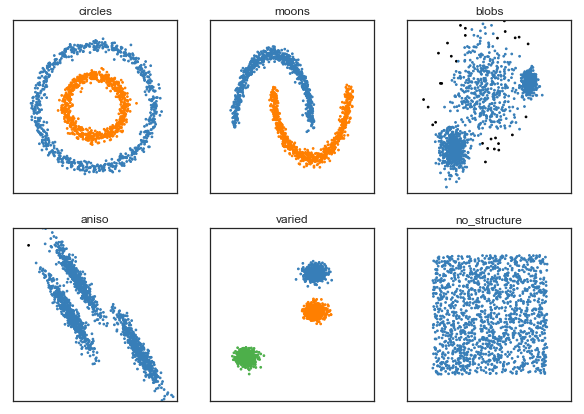

In [0]:
visualize_clusters(cluster_datasets, result_DBSCAN)

In [0]:
claster_metrics(DBSCAN(eps=0.25), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,1.000000,1.000000,1.000000,1.000000,1.000000,0.114364
1,moons,1.000000,1.000000,1.000000,1.000000,1.000000,0.389920
2,blobs,0.001746,0.019086,0.019694,0.204652,0.035931,0.238256
3,aniso,0.000005,0.000538,0.001305,0.077603,0.002566,0.514967
4,varied,1.000000,1.000000,1.000000,1.000000,1.000000,0.810432


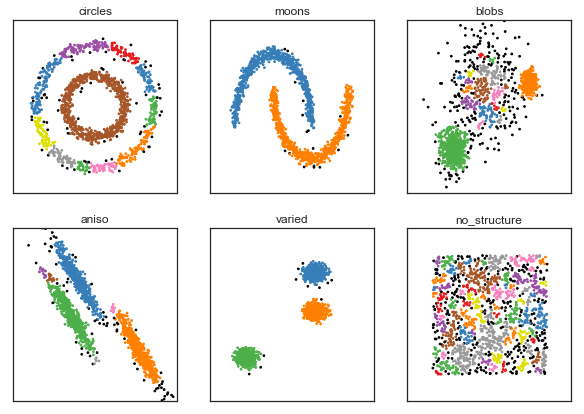

In [0]:
visualize_clusters(cluster_datasets, do_clustering(cluster_datasets, DBSCAN(eps=0.1)))

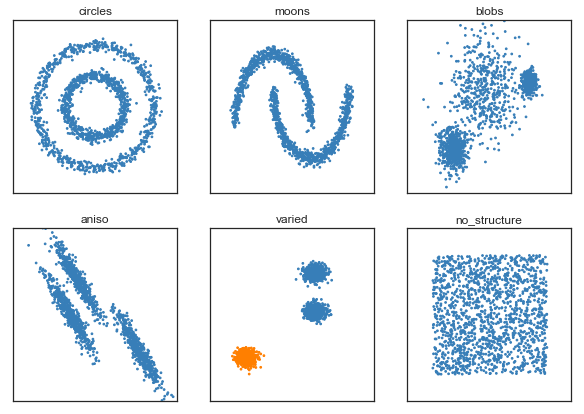

In [0]:
visualize_clusters(cluster_datasets, do_clustering(cluster_datasets, DBSCAN(eps=1)))

## Алгоритм [BIRCH](https://ru.wikipedia.org/wiki/BIRCH)

Реализован в библиотеке scikit-learn с помощью класса [Birch.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html)

In [0]:
from sklearn.cluster import Birch

In [0]:
%time result_Birch = do_clustering(cluster_datasets, Birch())

Wall time: 173 ms


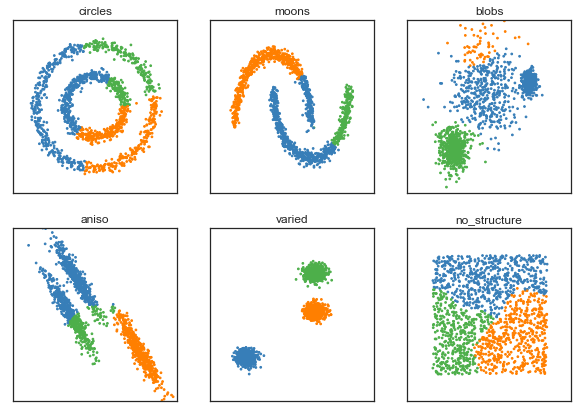

In [0]:
visualize_clusters(cluster_datasets, result_Birch)

In [0]:
claster_metrics(Birch(), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,0.004098,0.004165,0.007284,0.004797,0.005784,0.320526
1,moons,0.440833,0.420019,0.605025,0.420408,0.496097,0.373516
2,blobs,0.546238,0.565572,0.566103,0.779207,0.655777,0.506507
3,aniso,0.565599,0.608183,0.608660,0.657444,0.632112,0.463576
4,varied,1.000000,1.000000,1.000000,1.000000,1.000000,0.810432


## [Gaussian mixture models](https://en.wikipedia.org/wiki/Mixture_model)

[Реализация в scikit-learn.](https://scikit-learn.org/stable/modules/mixture.html)

In [0]:
from sklearn.mixture import GaussianMixture

In [0]:
%time result_GaussianMixture = do_clustering(cluster_datasets, GaussianMixture(n_components=3))

Wall time: 122 ms


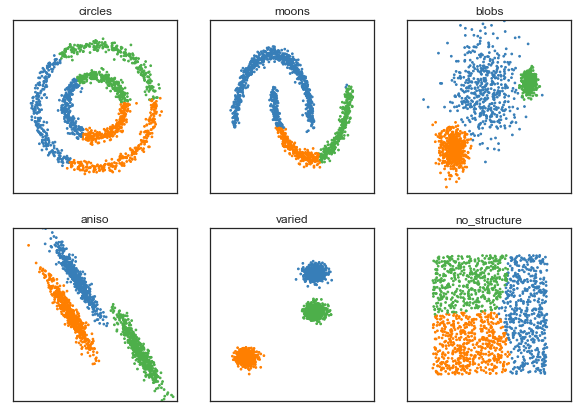

In [0]:
visualize_clusters(cluster_datasets, result_GaussianMixture)

In [0]:
claster_metrics(GaussianMixture(n_components=3), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,-0.000885,-0.000604,0.000006,0.000004,0.000005,0.388111
1,moons,0.499362,0.455980,0.631063,0.456359,0.529677,0.418442
2,blobs,0.966394,0.942084,0.942154,0.942176,0.942165,0.596284
3,aniso,1.000000,1.000000,1.000000,1.000000,1.000000,0.472360
4,varied,1.000000,1.000000,1.000000,1.000000,1.000000,0.810432


# Дополнительные источники

- [Открытый курс машинного обучения. Тема 7. Обучение без учителя: PCA и кластеризация](https://habr.com/ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации](https://habr.com/ru/post/321216/)
- [The 5 Clustering Algorithms Data Scientists Need to Know](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)